In [1]:
import json
import os
from pathlib import Path

import torch
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from sklearn.linear_model import LinearRegression

from data import constants
from data.eluc_data import ELUCData
from prescriptors.nsga2.torch_prescriptor import TorchPrescriptor
from prescriptors.nsga2.candidate import Candidate
from predictors.neural_network.neural_net_predictor import NeuralNetPredictor

In [2]:
dataset = ELUCData()

### Load Results

In [3]:
experiment_results_dir = Path("prescriptors/nsga2/trained_prescriptors/test")
stats_file = experiment_results_dir / "experiment_stats.csv"
# with open(stats_file) as csv_file:
#     stats_df = pd.read_csv(csv_file, sep=',')
last_gen_filename = os.path.join(experiment_results_dir, str(50) + '.csv')
last_gen_df = pd.read_csv(last_gen_filename)
pareto_df = last_gen_df[last_gen_df['NSGA-II_rank'] == 1]
# Sort by first objective, maximize: lowest to highest, minimize: highest to lowest
pareto_df = pareto_df.sort_values(by='change', ascending=True)

## Generation Plotting

In [4]:
def get_pareto_df(dir, gen):
    """
    Gets the pareto df for a given generation.
    :param dir: The experiment results directory.
    :param gen: The generation to get the pareto df for.
    """
    gen_filename = os.path.join(dir, f"{gen}.csv")
    gen_df = pd.read_csv(gen_filename)
    gen_pareto_df = gen_df[gen_df['NSGA-II_rank'] == 1]
    # Sort by first objective, maximize: lowest to highest, minimize: highest to lowest
    gen_pareto_df = gen_pareto_df.sort_values(by='change', ascending=True)
    gen_pareto_df["Name"] = f"Gen {gen}"
    return gen_pareto_df

def get_merged_df(dir, gens):
    """
    Gets the pareto df for multiple generations and merges them into one.
    :param dir: The experiment results directory.
    :param gens: List of generations to get the pareto df for.
    """
    dfs = []
    for gen in gens:
        dfs.append(get_pareto_df(dir, gen))
    merged_df = pd.concat(dfs, ignore_index=True)
    return merged_df

def get_overall_pareto_df(final_gen):
    pareto_list = []
    # First, go through each gen and add prescriptors that aren't already dominated.
    for gen in range(1, final_gen + 1):
        gen_filename = os.path.join(experiment_results_dir, f"{gen}.csv")        
        gen_df = pd.read_csv(gen_filename)
        gen_pareto_df = gen_df[gen_df['NSGA-II_rank'] == 1]
        for idx, row in gen_pareto_df.iterrows():
            pareto = True
            for p in pareto_list:
                # if (((p['ELUC'] < row['ELUC']) and (p['change'] <= row['change'])) or \
                #     ((p['ELUC'] <= row['ELUC']) and (p['change'] < row['change'])) or \
                #     ((p['ELUC'] == row['ELUC']) and (p['change'] == row['change']))):
                if p['ELUC'] <= row['ELUC'] and p['change'] <= row['change']:
                    pareto = False
                    break
            if pareto:
                pareto_list.append(row)

    # Go through the results and remove prescriptors that got dominated by later ones.
    filtered_pareto_list = []
    for i in range(len(pareto_list)):
        row = pareto_list[i]
        pareto = True
        for j in range(i+1, len(pareto_list)):
            p = pareto_list[j]
            # if (((p['ELUC'] < row['ELUC']) and (p['change'] <= row['change'])) or \
            #     ((p['ELUC'] <= row['ELUC']) and (p['change'] < row['change'])) or \
            #     ((p['ELUC'] == row['ELUC']) and (p['change'] == row['change']))):
            if p['ELUC'] <= row['ELUC'] and p['change'] <= row['change']:
                pareto = False
                break
        if pareto:
            filtered_pareto_list.append(row)

    return pd.DataFrame(filtered_pareto_list)


def plot_gens(dir, gens, save=False):
    """
    Plots the pareto front for multiple generations.
    :param dir: The experiment results directory.
    :param gens: List of generations to plot the pareto front for.
    """
    merged_df = get_merged_df(dir, gens)
    fig, ax = plt.subplots()
    cmap = plt.get_cmap("tab10")
    colors = [cmap(i) for i in [0, 1, 2, 5, 4]]
    curve_names = []
    for i, gen in enumerate(gens):
        curve_name = f"Gen {gen}"
        curve_names.append(curve_name)

        merged_df[merged_df["Name"] == curve_name].plot(x='change',
                       y='ELUC',
                       marker='o',
                       ylabel='ELUC',
                       ax=ax,
                       color=colors[i],
                       label="Gen " + str(gen))

    overall_pareto_df = get_overall_pareto_df(gens[-1])
    overall_pareto_df = overall_pareto_df.sort_values(by="change")
    overall_pareto_df.plot(x='change', y='ELUC', c='r', marker='o', ax=ax, label="Final Pareto Front")
    #plt.xlim(0, 0.4)
    plt.grid() 
    # handles, labels = plt.gca().get_legend_handles_labels()
    # order = [0, 1, 2, 4, 3]
    # plt.legend([handles[idx] for idx in order], [curve_names[idx] for idx in order], loc="upper right")
    plt.legend(prop={'size': 9})
    #plt.title("Pareto Fronts Across Generations")
    if save:
        plt.savefig("figures/pareto.png", format="png", dpi=300)
    plt.show()

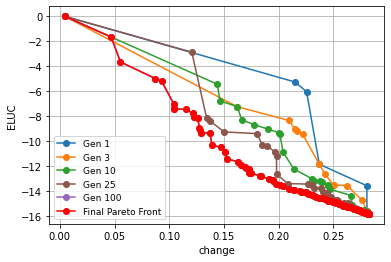

In [5]:
plot_gens(experiment_results_dir, [1, 3, 10, 25, 100], save=False)

In [6]:
def get_gen_df(gen):
    gen_filename = os.path.join(experiment_results_dir, f"{gen}.csv")
    gen_df = pd.read_csv(gen_filename)
    # Sort by first objective, maximize: lowest to highest, minimize: highest to lowest
    gen_df = gen_df.sort_values(by='change', ascending=True)
    gen_df["Name"] = f"Gen {gen}"
    return gen_df

def get_all_gens_df(gens):
    dfs = []
    for gen in gens:
        dfs.append(get_gen_df(gen))
    merged_df = pd.concat(dfs, ignore_index=True)
    return merged_df

In [7]:
def plot_all_gens(dir, gens, save=False):
    all_gens_df = get_all_gens_df(gens)
    fig, ax = plt.subplots()

    all_gens_df.plot.scatter(x='change',
                             y='ELUC',
                             ax=ax,
                             label="All prescriptors evaluated")
    # Plot last gen's pareto front in red
    
    #get_pareto_df(dir, gens[-1]).plot.scatter(x='change', y='ELUC', c='red', ax=ax, label="Gen 100 Pareto Front")
    overall_pareto = get_overall_pareto_df(gens[-1])
    overall_pareto.plot.scatter(x='change', y='ELUC', c='red', ax=ax, label="Final Pareto Front")
    plt.grid()
    #plt.title("All Generations All Prescriptor Performance")
    plt.legend(loc="upper left")
    if save:
        plt.savefig("figures/allgens.png", format="png", dpi=300) 
    plt.show()

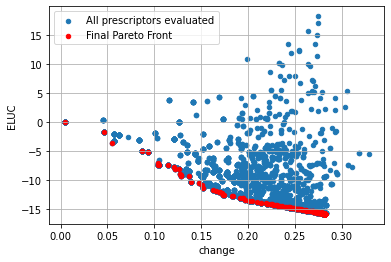

In [8]:
plot_all_gens(experiment_results_dir, [a + 1 for a in range(100)], save=False)

In [9]:
all_gen_pareto_df = get_overall_pareto_df(100)
all_gen_pareto_df["id"] = all_gen_pareto_df["gen"].astype(str) + "_" + all_gen_pareto_df["id"].astype(str)
all_gen_pareto_df.head()

,gen,id,parents,NSGA-II_rank,distance,ELUC,change
0,1,1_1,"(None, None)",1,inf,0.020065,0.004293
27,17,17_82,"((10, 76), (16, 96))",1,0.081190,-15.719939,0.279222
39,23,23_92,"((19, 64), (19, 4))",1,0.012726,-15.797996,0.281420
42,30,30_59,"((26, 1), (17, 82))",1,0.014635,-15.673841,0.277722
1,34,34_85,"((20, 76), (11, 25))",1,0.456917,-5.203246,0.093168


## Heuristic Pareto

In [10]:
def perfect_prescribe_row(row, reco_coefs, pct_change):
    # Weird case where row is all zeroes
    if row[constants.LAND_USE_COLS].sum() == 0:
        return row
    scaled_change = pct_change * row[constants.LAND_USE_COLS].sum()
    best_col = reco_coefs[-1][0]
    max_change = min(row[constants.RECO_COLS].sum() - row[best_col], scaled_change)
    changed = 0
    for coef in reco_coefs:
        if not coef[0] == best_col: # This technically shouldn't be necessary
            # If we have more change left than there is in this column, delete it all
            if row[coef[0]] < max_change - changed:
                changed += row[coef[0]]
                row[coef[0]] = 0
            # Otherwise, remove however much change is left
            else:
                row[coef[0]] -= (max_change - changed)
                changed = max_change
                break
    row[best_col] += changed
    return row


def even_prescribe_row(row, pct_change, best_col):
    # Weird case where row is all zeroes
    if row[constants.LAND_USE_COLS].sum() == 0:
        return row
    scaled_change = pct_change * row[constants.LAND_USE_COLS].sum()
    presc_cols = [col for col in constants.RECO_COLS]
    presc_cols.remove(best_col)
    row_sum = row[presc_cols].sum()
    max_change = min(row_sum, scaled_change)
    row[presc_cols] = row[presc_cols].apply(lambda col: col - (col/row_sum) * max_change if col - (col/row_sum) * max_change >= 0 else 0)
    row[best_col] = row[best_col] + max_change
    return row

In [11]:
def perfect_prescribe(context, pct_change, coefs):
    """
    Perfect prescription algorithm:
        1. Add to forest as much pct change as possible up to forest = 1
        2. Subtract from bottom up however much was changed
    """

    adjusted = context.copy()
    coefficients = zip(constants.LAND_USE_COLS, coefs)
    reco_coefs = [coef for coef in coefficients if coef[0] in constants.RECO_COLS]
    reco_coefs = sorted(reco_coefs, key=lambda x: x[1], reverse=True)
    adjusted = adjusted.apply(lambda row: perfect_prescribe_row(row, reco_coefs, pct_change), axis=1)
    return adjusted


def even_prescribe(context, pct_change, best_col):
    """
    Takes evenly from all columns and adds to best col
    """
    adjusted = context.copy()
    adjusted = adjusted.apply(lambda row: even_prescribe_row(row, pct_change, best_col), axis=1)
    return adjusted


def heuristic_prescribe_and_predict(context_df, predictor, presc_func, *presc_args):
    """
    Given a context and a heuristic function, prescribe actions and predict the resulting ELUC.
    :param context_df: The context dataframe.
    :param dummy_prescriptor: A dummy prescriptor to perform standard ELUC prediction.
    :param presc_func: The heuristic function to prescribe actions.
    :param presc_args: The arguments to pass to the heuristic function.
    """
    reco_df = presc_func(context_df, *presc_args)
    prescribed_actions_df = reco_df[constants.RECO_COLS] - context_df[constants.RECO_COLS]

    # Rename the columns to match what the predictor expects
    prescribed_actions_df = prescribed_actions_df.rename(constants.RECO_MAP, axis=1)
    prescribed_actions_df[constants.NO_CHANGE_COLS] = 0
    
    # Aggregate the context and actions dataframes.
    context_actions_df = pd.concat([context_df, prescribed_actions_df[constants.DIFF_LAND_USE_COLS]], axis=1)
    
    # Reorder
    prescribed_actions_df = context_actions_df[constants.DIFF_LAND_USE_COLS]

    eluc = predictor.predict(context_actions_df)
    change = (prescribed_actions_df[prescribed_actions_df > 0].sum(axis=1) / context_actions_df[constants.LAND_USE_COLS].sum(axis=1))
    
    context_actions_df["ELUC"] = eluc
    context_actions_df["change"] = change
    return context_actions_df

In [12]:
nnp = NeuralNetPredictor()
nnp.load("predictors/neural_network/trained_models/no_overlap_nn")
presc_config = None
# with open("prescriptors/unileaf_configs/config-loctime-crop-nosoft.json") as f:
#     presc_config = json.load(f)
# dummy_prescriptor = UnileafPrescriptor(presc_config,
#                                    dataset.train_df.iloc[:1],
#                                    dataset.encoder,
#                                    [nnp])



test_df = dataset.test_df.sample(frac=0.01, random_state=100)
encoded_test_df = dataset.encoder.encode_as_df(test_df)

candidate_params = {"in_size": len(constants.CAO_MAPPING["context"]), "hidden_size": 16, "out_size": len(constants.RECO_COLS)}
prescriptor = TorchPrescriptor(100, 
                               100, 
                               0.2, 
                               test_df, 
                               dataset.encoder, 
                               nnp, 
                               4096, 
                               candidate_params, 
                               seed_dir="prescriptors/nsga2/seeds/test")

context_df = test_df[constants.CAO_MAPPING["context"]]
encoded_context_df = encoded_test_df[constants.CAO_MAPPING["context"]]

### Even Prescriptors

In [13]:
#pcts = [i / len(all_gen_pareto_df["id"].unique()) for i in range(1, len(all_gen_pareto_df["id"].unique()) + 1)]
n_points = 10
pcts = [i / n_points for i in range(1, n_points + 1)]

even_elucs = []
even_changes = []
best_col = "secdf"
for pct in tqdm(pcts):
    result_df = heuristic_prescribe_and_predict(context_df, nnp, even_prescribe, pct, best_col)
    even_elucs.append(result_df["ELUC"].mean())
    even_changes.append(result_df["change"].mean())

print(even_elucs)
print(even_changes)

100%|██████████| 10/10 [02:41<00:00, 16.12s/it]

[-4.314813, -7.634704, -10.661896, -13.494146, -16.112873, -18.506008, -20.642227, -22.501228, -24.030687, -24.92859]
[0.06396448144266076, 0.12165281867888075, 0.17531225099440512, 0.22532780872604177, 0.27171696820353775, 0.3142749020592196, 0.3525348565948521, 0.38632015816018705, 0.41513341316156893, 0.43227518547135796]


### "Perfect" Prescriptors

In [14]:
linreg = LinearRegression()
linreg.fit(dataset.train_df[constants.DIFF_LAND_USE_COLS], dataset.train_df["ELUC"])
print(linreg.coef_)

[110.33926   58.705685 -56.392277  22.260334  27.738625 -16.832415
  26.697311  72.008316]


In [15]:
coefs = linreg.coef_

perfect_elucs = []
perfect_changes = []
for pct in tqdm(pcts):
    result_df = heuristic_prescribe_and_predict(context_df, nnp, perfect_prescribe, pct, coefs)
    perfect_elucs.append(result_df["ELUC"].mean())
    perfect_changes.append(result_df["change"].mean())

print(perfect_elucs)
print(perfect_changes)

100%|██████████| 10/10 [01:50<00:00, 11.10s/it]

[-5.185271, -9.223923, -12.634682, -15.580735, -18.107555, -20.237253, -21.95781, -23.304686, -24.341927, -24.92859]
[0.06396448144266076, 0.12165281867888075, 0.17531225099440512, 0.22532780872604177, 0.27171696820353775, 0.3142749020592196, 0.3525348565948521, 0.38632015816018705, 0.41513341316156893, 0.43227518547135796]


### Trained Prescriptors

In [16]:
def load_prescriptor(id, verbose=False):
    gen = int(id.split('_')[0])
    prescriptor_model_filename = os.path.join(experiment_results_dir,
                                          str(gen),
                                          id + '.h5')
    if verbose:
        print(f'Loading prescriptor model: {prescriptor_model_filename}')
    prescriptor_model = load_model(prescriptor_model_filename, compile=False)
    return prescriptor_model

def load_torch_prescriptor(id: str) -> Candidate:
    gen = id.split('_')[0]
    prescriptor_model_filename = experiment_results_dir / f"{int(gen)+1}" / f"{id}.pt"
    prescriptor_model = Candidate(**candidate_params)
    prescriptor_model.load_state_dict(torch.load(prescriptor_model_filename))
    return prescriptor_model

In [18]:
def trained_prescribe_and_predict(id, prescriptor):
    candidate = load_torch_prescriptor(id)
    context_actions_df = prescriptor.prescribe(candidate)
    eluc_df, change_df = prescriptor.predict(context_actions_df)
    context_actions_df["ELUC"] = eluc_df["ELUC"]
    context_actions_df["change"] = change_df["change"]
    return context_actions_df

trained_elucs = []
trained_changes = []
print(len(all_gen_pareto_df))
for id in tqdm(all_gen_pareto_df["id"].unique()):
    candidate = load_torch_prescriptor(id)
    evaluated_context_actions_df = trained_prescribe_and_predict(id, prescriptor)
    trained_elucs.append(evaluated_context_actions_df["ELUC"].mean())
    trained_changes.append(evaluated_context_actions_df["change"].mean())

168


100%|██████████| 168/168 [00:41<00:00,  4.01it/s]


[-4.314813, -7.634704, -10.661896, -13.494146, -16.112873, -18.506008, -20.642227, -22.501228, -24.030687, -24.92859]
[0.06396448144266076, 0.12165281867888075, 0.17531225099440512, 0.22532780872604177, 0.27171696820353775, 0.3142749020592196, 0.3525348565948521, 0.38632015816018705, 0.41513341316156893, 0.43227518547135796]
[-5.185271, -9.223923, -12.634682, -15.580735, -18.107555, -20.237253, -21.95781, -23.304686, -24.341927, -24.92859]
[0.06396448144266076, 0.12165281867888075, 0.17531225099440512, 0.22532780872604177, 0.27171696820353775, 0.3142749020592196, 0.3525348565948521, 0.38632015816018705, 0.41513341316156893, 0.43227518547135796]
[0.011927317, -24.724113, -24.911802, -24.3438, -6.9459214, -24.676634, -22.6536, -18.411762, -24.92859, -24.180197, -24.620905, -24.92859, -24.559345, -24.925245, -24.920744, -14.4887, -21.993177, -24.92859, -24.486448, -21.95749, -24.91975, -24.633379, -20.840147, -22.461676, -24.92859, -22.788837, -22.517761, -24.923029, -24.92838, -22.00117,

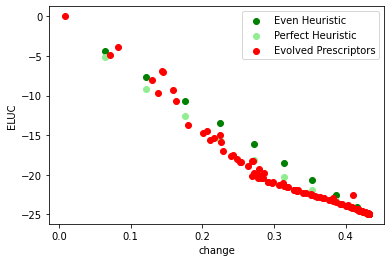

In [19]:
print(even_elucs)
print(even_changes)
print(perfect_elucs)
print(perfect_changes)
print(trained_elucs)
print(trained_changes)
print(dict(zip(constants.DIFF_LAND_USE_COLS, coefs)))
plt.scatter(even_changes, even_elucs, color="green", label="Even Heuristic")
plt.scatter(perfect_changes, perfect_elucs, color="lightgreen", label="Perfect Heuristic")
plt.scatter(trained_changes, trained_elucs, color="red", label="Evolved Prescriptors")
plt.legend()
plt.xlabel("change")
plt.ylabel("ELUC")
#plt.savefig("figures/heuristics.png", format="png", dpi=300)
plt.show()

In [20]:
def filter_dominating(changes, elucs):
    """
    Gets indices of points that are not dominated by any other point.
    """
    non_dominated_idxs = []
    for i in range(len(changes)):
        dominated = False
        for j in range(len(changes)):
            if i != j and changes[i] >= changes[j] and elucs[i] >= elucs[j]:
                dominated = True
                break
        if not dominated:
            non_dominated_idxs.append(i)
    return non_dominated_idxs


def two_dim_decreasing_neg_hypervolume(x, y, right=1):
    """
    Computes the hypervolume of a 2d pareto.
    We use the sklearn AUC function to find the area between our curve and y = 0,
    then we add the area of the rectangle to the right of the pareto.
    This assumes the y coordinate of the reference point is 0 (which it is in our ELUC case).
    We only consider points under y = 0, adding point 0,0 to the pareto if it is not there.
    :param x: List of x coordinates between [0, 1]
    :param y: List of y coordinates
    :param right: the rightmost edge to compute the rectangle to. Defaults to 1.
    """

    assert len(x) == len(y)
    assert all([0 <= x_i <= 1 for x_i in x])
    assert right >= max(x)

    # Filter out positive y values
    neg_idxs = [i for i in range(len(y)) if y[i] < 0]
    x = [x[i] for i in neg_idxs]
    y = [y[i] for i in neg_idxs]

    # Sort the pareto by x
    sorted_x = sorted(x)
    sorted_y = [y[x.index(sorted_x[i])] for i in range(len(x))]

    # Add point 0,0 if it is not there
    if sorted_x[0] != 0:
        sorted_x = [0] + sorted_x
        sorted_y = [0] + sorted_y

    # Add bottom right point if it is not there
    if sorted_x[-1] != right:
        sorted_x.append(right)
        sorted_y.append(sorted_y[-1])

    # Take the rectangle that is to the top right of each point.
    area = 0
    for i in range(len(sorted_x) - 2, -1, -1):
        area += (sorted_x[i] - sorted_x[i + 1]) * sorted_y[i]

    return area

19.12184631485107
19.6768629004944
20.019761543818568


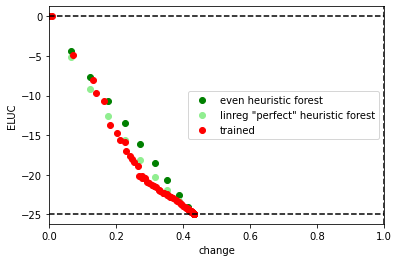

In [21]:
# Filter out points that are dominated by others
idxs = filter_dominating(trained_changes, trained_elucs)
trained_changes_filtered = [trained_changes[i] for i in idxs]
trained_elucs_filtered = [trained_elucs[i] for i in idxs]

print(two_dim_decreasing_neg_hypervolume(even_changes, even_elucs))
print(two_dim_decreasing_neg_hypervolume(perfect_changes, perfect_elucs))
print(two_dim_decreasing_neg_hypervolume(trained_changes_filtered, trained_elucs_filtered))

trained_changes_sorted = sorted(trained_changes_filtered)
trained_elucs_sorted = [trained_elucs_filtered[trained_changes_filtered.index(change)] for change in trained_changes_sorted]

plt.scatter([0] + even_changes, [0] + even_elucs, color="green", label="even heuristic forest")
plt.scatter([0] + perfect_changes, [0] + perfect_elucs, color="lightgreen", label="linreg \"perfect\" heuristic forest")
plt.scatter([0] + trained_changes_sorted, [0] + trained_elucs_sorted, color="red", label="trained")
plt.legend()
plt.xlabel("change")
plt.ylabel("ELUC")
plt.xlim([0, 1])

plt.axhline(0, color="black", linestyle="--")
plt.axhline(min([min(even_elucs), min(perfect_elucs), min(trained_elucs)]), color="black", linestyle="--")
plt.axvline(1, color="black", linestyle="--")
plt.show()

## Examine Results

5 0.3142749020592196 -18.506008
5 0.3142749020592196 -20.237253
19 0.2914209861971803 -20.89566


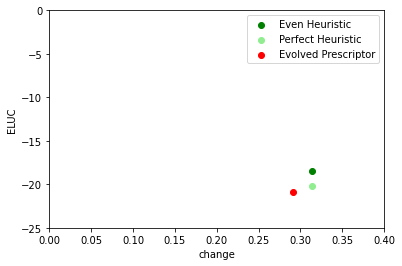

In [22]:
def get_idx_close(change, changes):
    diff = [abs(c - change) for c in changes]
    idx = diff.index(min(diff))
    return idx

pct = 0.3
trained_idx = get_idx_close(pct, trained_changes_sorted) - 1
even_idx = get_idx_close(pct, even_changes)
perfect_idx = get_idx_close(pct, perfect_changes)

print(even_idx, even_changes[even_idx], even_elucs[even_idx])
print(perfect_idx, perfect_changes[perfect_idx], perfect_elucs[perfect_idx])
print(trained_idx, trained_changes_sorted[trained_idx], trained_elucs_sorted[trained_idx])

plt.scatter([even_changes[even_idx]], [even_elucs[even_idx]], color="green", label="Even Heuristic")
plt.scatter([perfect_changes[perfect_idx]], [perfect_elucs[perfect_idx]], color="lightgreen", label="Perfect Heuristic")
plt.scatter([trained_changes_sorted[trained_idx]], [trained_elucs_sorted[trained_idx]], color="red", label="Evolved Prescriptor")
plt.legend()
plt.xlabel("change")
plt.ylabel("ELUC")
plt.xlim([0, 0.4])
plt.ylim([-25, 0])
#plt.title("Average Change vs. ELUC for ~20% change prescriptors")
#plt.savefig("figures/prescmeans.png", format="png", dpi=300)
plt.show()

In [23]:
trained_idx_unsort = trained_changes.index(trained_changes_sorted[trained_idx])
trained_result = trained_prescribe_and_predict(all_gen_pareto_df["id"].unique()[trained_idx_unsort], prescriptor)
even_result = heuristic_prescribe_and_predict(context_df, nnp, even_prescribe, pcts[even_idx], best_col)
perfect_result = heuristic_prescribe_and_predict(context_df, nnp, perfect_prescribe, pcts[perfect_idx], coefs)

# trained_result = trained_result.set_index(even_result.index)

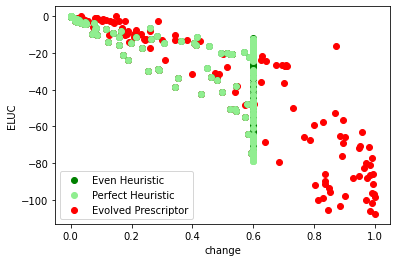

In [24]:
trained_sample = trained_result.sample(frac=0.01, random_state=42)
even_sample = even_result.loc[trained_sample.index]
perfect_sample = perfect_result.loc[trained_sample.index]

plt.scatter(trained_sample["change"], trained_sample["ELUC"], color="red", label="Evolved Prescriptor")
plt.scatter(even_sample["change"], even_sample["ELUC"], color="green", label="Even Heuristic")
plt.scatter(perfect_sample["change"], perfect_sample["ELUC"], color="lightgreen", label="Perfect Heuristic")
# Rearrange legend (from stackoverflow)
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 2, 0]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
plt.xlabel("change")
plt.ylabel("ELUC")
#plt.title("Expanded view of ~20% change prescriptors (subsampled)")
#plt.savefig("figures/prescexpanded.png", format="png", dpi=300)
plt.show()

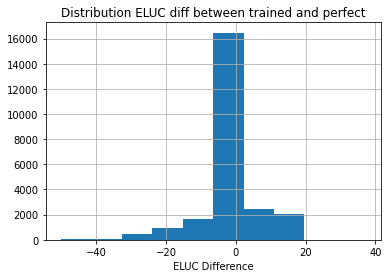

In [25]:
eluc_diff = trained_result["ELUC"] - perfect_result["ELUC"]
plt.title("Distribution ELUC diff between trained and perfect")
plt.xlabel("ELUC Difference")
plt.hist(eluc_diff)
plt.grid()
plt.show()

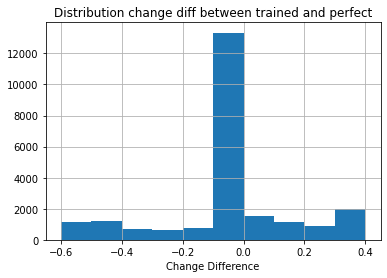

In [26]:
change_diff = trained_result["change"] - perfect_result["change"]
plt.title("Distribution change diff between trained and perfect")
plt.xlabel("Change Difference")
plt.hist(change_diff)
plt.grid()
plt.show()

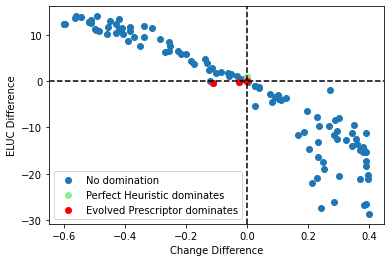

In [27]:
diff_df = pd.DataFrame()
diff_df["change"] = trained_sample["change"] - perfect_sample["change"]
diff_df["ELUC"] = trained_sample["ELUC"] - perfect_sample["ELUC"]
dom = diff_df[(diff_df["change"] < 0) & (diff_df["ELUC"] < 0)]
other_dom = diff_df[(diff_df["change"] > 0) & (diff_df["ELUC"] > 0)]
plt.scatter(diff_df["change"], diff_df["ELUC"], label="No domination")
plt.scatter(other_dom["change"], other_dom["ELUC"], color="lightgreen", label="Perfect Heuristic dominates")
plt.scatter(dom["change"], dom["ELUC"], color="red", label="Evolved Prescriptor dominates")
plt.axhline(0, color="black", linestyle="--")
plt.axvline(0, color="black", linestyle="--")
plt.xlabel("Change Difference")
plt.ylabel("ELUC Difference")
#plt.title("Change Diff vs. ELUC Diff Between Trained and Perfect (subsampled)")
plt.legend()
#plt.savefig("figures/prescdiffs.png", format="png", dpi=300)
plt.show()

In [28]:
low_change_idx = change_diff[(change_diff < 0)].index
low_change_eluc_diff = eluc_diff[low_change_idx]
low_change_neg_eluc_diff = low_change_eluc_diff[low_change_eluc_diff < 0]
print(f"Number less change better ELUC: {len(low_change_neg_eluc_diff)}")
min_idx = low_change_neg_eluc_diff.sort_values().index[0]
print(f"Max difference in ELUC with less change: {eluc_diff[min_idx]}")

print("Changes")
print(even_result.loc[min_idx]["change"], perfect_result.loc[min_idx]["change"], trained_result.loc[min_idx]["change"])
print()
print("ELUCs")
print(even_result.loc[min_idx]["ELUC"], perfect_result.loc[min_idx]["ELUC"], trained_result.loc[min_idx]["ELUC"])
print()
print([f"{col}: {even_result.loc[min_idx][col]}" for col in constants.CAO_MAPPING["context"]])
print("Prescribed:")
print([f"{col}: {even_result.loc[min_idx][col]}" for col in constants.DIFF_RECO_COLS])
print([f"{col}: {perfect_result.loc[min_idx][col]}" for col in constants.DIFF_RECO_COLS])
print([f"{col}: {trained_result.loc[min_idx][col]}" for col in constants.DIFF_RECO_COLS])


Number less change better ELUC: 265
Max difference in ELUC with less change: -3.4861202239990234
Changes
0.6000000044703483 0.6000000044703483 0.5675060749053955

ELUCs
-24.130861282348633 -26.944133758544922 -30.430253982543945

['crop: 0.1459043025970459', 'pastr: 0.0', 'primf: 0.0', 'primn: 0.010675199329853058', 'range: 0.5323649644851685', 'secdf: 0.0', 'secdn: 0.3110555410385132', 'urban: 0.0', 'cell_area: 64159.56640625', 'lat: 33.875', 'lon: 49.625', 'time: 2016.0']
Prescribed:
['crop_diff: -0.08848720004986244', 'pastr_diff: 0.0', 'range_diff: -0.3228656336615175', 'secdf_diff: 0.6000000044703483', 'secdn_diff: -0.1886471707589684']
['crop_diff: -0.1459043025970459', 'pastr_diff: 0.0', 'range_diff: -0.4540957018733024', 'secdf_diff: 0.6000000044703483', 'secdn_diff: 0.0']
['crop_diff: -0.1459043025970459', 'pastr_diff: 0.0', 'range_diff: -0.1105462908744812', 'secdf_diff: 0.5675060749053955', 'secdn_diff: -0.3110555410385132']


In [29]:
# How many are greater than the MAE of predictor model
signif = low_change_neg_eluc_diff[abs(low_change_neg_eluc_diff) > 0.05]
print(f"Number of points where trained prescriptor prescribes less change than perfect heuristic AND produces better ELUC by more than predictor model MAE: {len(signif)}")
print(f"Average difference in change for these points: {change_diff.loc[signif.index].mean()}")
print(f"Average difference in ELUC for these points: {signif.mean()}")

Number of points where trained prescriptor prescribes less change than perfect heuristic AND produces better ELUC by more than predictor model MAE: 114
Average difference in change for these points: -0.03607012552560704
Average difference in ELUC for these points: -1.1081910133361816


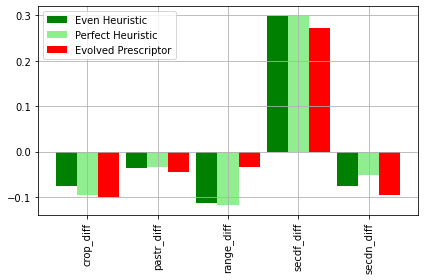

In [30]:
even_total_diffs = even_result[constants.DIFF_RECO_COLS].mean()
perfect_total_diffs = perfect_result[constants.DIFF_RECO_COLS].mean()
trained_total_diffs = trained_result[constants.DIFF_RECO_COLS].mean()

xticks = np.arange(len(constants.DIFF_RECO_COLS))

plt.bar(xticks-0.3, even_total_diffs, 0.3, label="Even Heuristic", color="green")
plt.bar(xticks, perfect_total_diffs, 0.3, label="Perfect Heuristic", color="lightgreen")
plt.bar(xticks+0.3, trained_total_diffs, 0.3, label="Evolved Prescriptor", color="red")
plt.xticks(xticks, constants.DIFF_RECO_COLS, rotation=90)
plt.legend()
plt.grid()
#plt.title("Average land use change for each prescriptor")
fig = plt.gcf()
fig.set_tight_layout(True)
#plt.savefig("figures/prescbar.png", format="png", dpi=300)
plt.show()

#### See what features cause more change

[0.7305141286689001, 0.4978409199696584, -0.37435125161483457, -0.29019378701503845, -0.05222642897556912, -0.20694611325111933, 0.545512498425696, 0.11259528270954572, 0.4190737296588397, -0.3560861002991157, -0.3777756639593425, 0.01909128492692784]


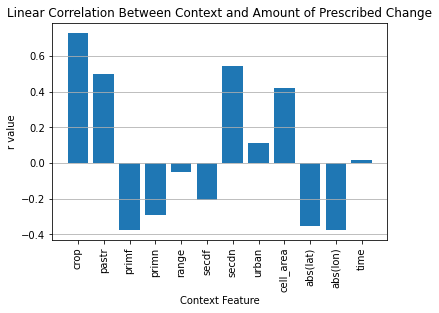

In [31]:
rs = []
for col in constants.LAND_USE_COLS + constants.NONLAND_FEATURES:
    feat = trained_result[col]
    if col == "lat" or col == "lon":
        feat = abs(feat)
    rs.append(feat.corr(trained_result["change"]))
print(rs)

labels = constants.LAND_USE_COLS + constants.NONLAND_FEATURES
labels[labels.index("lat")] = "abs(lat)"
labels[labels.index("lon")] = "abs(lon)"
plt.bar(labels, rs)
plt.xticks(rotation=90)
plt.xlabel("Context Feature")
plt.ylabel("r value")
plt.title("Linear Correlation Between Context and Amount of Prescribed Change")
plt.grid(axis="y")
#plt.savefig("figures/corr.png", format="png", dpi=300)
plt.show()

In [32]:
def plot_context_change(feature, save):
    plt.scatter(trained_sample[feature], trained_sample["change"])
    plt.title(f"Context {feature} vs. Amount of Prescribed Change")
    plt.ylabel("Change")
    plt.xlabel(feature)
    if feature in constants.LAND_USE_COLS:
        plt.plot([0, 1], [0, 1], color="black", linestyle="--", label="y=x")
        plt.plot([0, 1], [1, 0], color="red", linestyle="--", label="y=1-x")
        plt.legend()
    if save:
        plt.savefig(f"figures/{feature}change.png", format="png", dpi=300)
    plt.show()

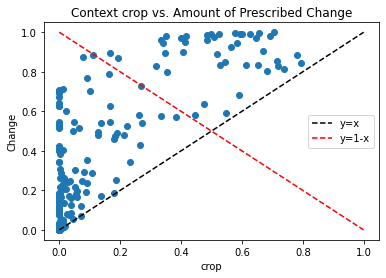

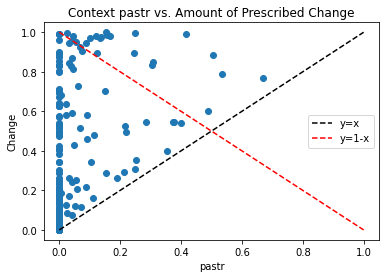

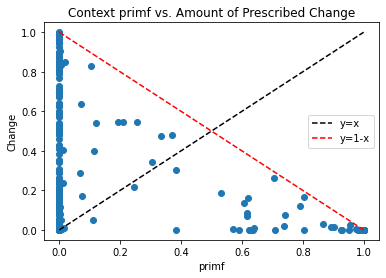

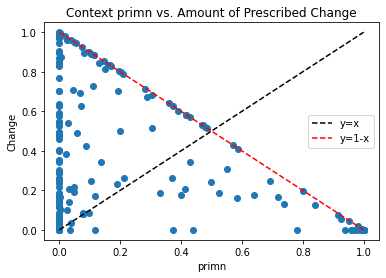

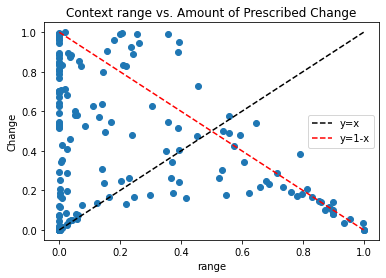

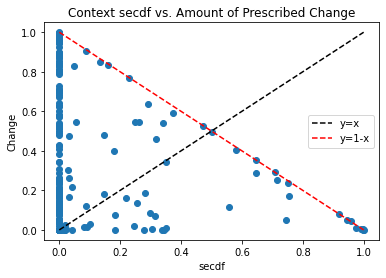

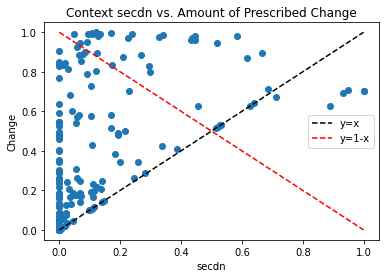

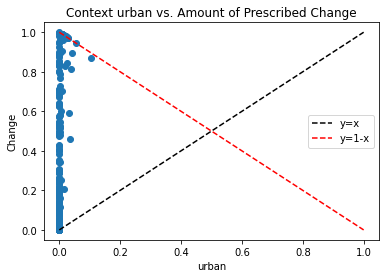

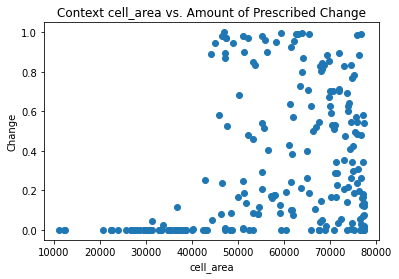

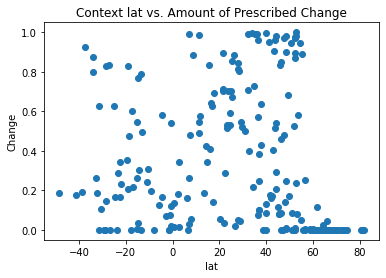

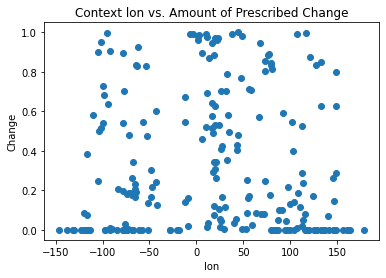

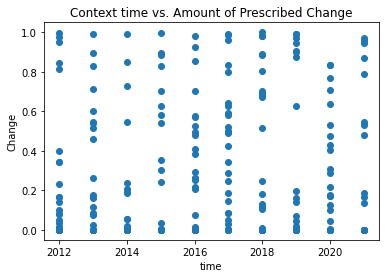

In [33]:
for feature in constants.LAND_USE_COLS + constants.NONLAND_FEATURES:
    plot_context_change(feature, False)

## Compare to Global Warming

In [35]:
pcts = [0.01, 0.05, 0.1, 0.2, 0.5, 1]
total_emissions = []
total_changes = []
for pct in tqdm(pcts):
    result_df = heuristic_prescribe_and_predict(dataset.test_df.loc[2021][constants.CAO_MAPPING["context"]], nnp, perfect_prescribe, pct, linreg.coef_)
    result_df["total_emissions"] = result_df["ELUC"] * result_df["cell_area"]
    result_df["total_change"] = result_df["change"] * result_df["cell_area"]
    total_emissions.append(result_df["total_emissions"].sum())
    total_changes.append(result_df["total_change"].sum() / result_df["cell_area"].sum())

KeyboardInterrupt: 

In [ ]:
# Weight of CO2 vs. C
conversion = 3.664
# Remaining Carbon budget
rcb = 250
rcb2 = 1200
# Yearly net emissions
yearly = 20

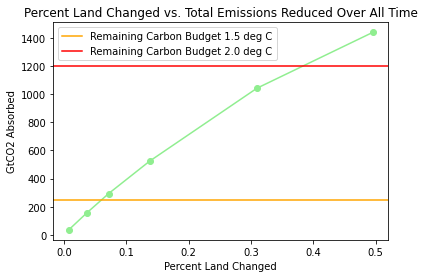

In [ ]:
fig = plt.figure(facecolor="white")
plt.plot(total_changes, [-1 * t * conversion / 1e9 for t in total_emissions], marker="o", color="lightgreen")
plt.axhline(y=rcb, color='orange', label="Remaining Carbon Budget 1.5 deg C")
plt.axhline(y=rcb2, color='red', label="Remaining Carbon Budget 2.0 deg C")
plt.legend()
plt.title("Percent Land Changed vs. Total Emissions Reduced Over All Time")
plt.ylabel("GtCO2 Absorbed")
plt.xlabel("Percent Land Changed")
plt.show()

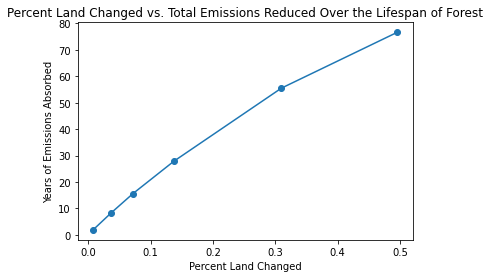

In [ ]:
fig = plt.figure(facecolor="white")
plt.plot(total_changes, [t / (-18.78e9 / conversion) for t in total_emissions], marker="o")
plt.title("Percent Land Changed vs. Total Emissions Reduced Over the Lifespan of Forest")
plt.xlabel("Percent Land Changed")
plt.ylabel("Years of Emissions Absorbed")
plt.show()